This code was adapted from Chris Holden (ceholden@gmail.com) Chaoter 5 Lesson on Ladncover Classification: https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html - https://github.com/ceholden



### Imports

In [49]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Sklearn Libraries
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

### Preparing The Dataset

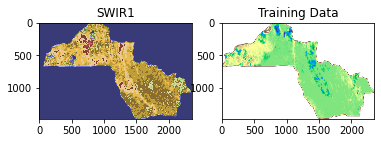

In [16]:
# Read in our satellite and label image
satellite_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/filled_l8_training_data.tif', gdal.GA_ReadOnly)
training_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/esa_landcover_training_data.tif', gdal.GA_ReadOnly)

img = np.zeros((satellite_img.RasterYSize, satellite_img.RasterXSize, satellite_img.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(satellite_img.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = satellite_img.GetRasterBand(b + 1).ReadAsArray()
    
lbls = training_img.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.tab20b)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(lbls, cmap=plt.cm.terrain)
plt.title('Training Data')

plt.show()

In [17]:
#img.shape

In [18]:
#lbls.shape

Creating the X feature matrix array and the y labels matrix to be fed into the Random Forest

In [19]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (lbls > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(lbls[lbls > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#this is a wuick numpy trick for flattening
X = img[lbls > 0, :]  # include 8th band, which is Fmask, for now
y = lbls[lbls > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))



We have 3489499 samples
The training data include 9 classes: [1 2 3 4 5 6 7 8 9]
Our X matrix is sized: (3489499, 7)
Our y array is sized: (3489499,)


### Training The Random Forest

In [35]:
#stratified k-cross validation to balance the classes
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

10

In [36]:
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 172508  172509  172510 ... 3489496 3489497 3489498] TEST: [     0      1      2 ... 848008 848009 849648]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 172508  172509  172510 ... 1163191 1163192 1163193]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 226614  226615  226616 ... 1436561 1436562 1436563]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 252500  252501  252502 ... 1697912 1697913 1697914]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 276030  276031  276032 ... 2010759 2010760 2010761]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 337129  337130  337131 ... 2260741 2260742 2260743]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 348880  348881  348882 ... 2553425 2553426 2553427]
TRAIN: [      0       1       2 ... 3489496 3489497 3489498] TEST: [ 360664  360665  360666 ... 2901754 2901755 2901756]
TRAIN: [      0       1       2 ... 34

In [26]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #stratify=y, random_state=123456

In [37]:
X_train.shape

(3140550, 7)

In [38]:
X_test.shape

(348949, 7)

In [39]:
y_train.shape

(3140550,)

In [40]:
y_test.shape

(348949,)

In [41]:
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

### Validating the Random Forest

In [42]:
val = rf.predict(X_test)

### Accuracy

In [43]:
target_names = ['Cropland', 'Mosaic Cropland', 'Mosaic Vegetation', 'Forest',
                         'Shrubland', 'Grassland', 'Urban', 'Water', 'No Data'
                                                           ]

In [44]:
print(classification_report(y_test, val, target_names=target_names))

                   precision    recall  f1-score   support

         Cropland       0.25      0.07      0.11      7097
  Mosaic Cropland       0.10      0.00      0.00      1893
Mosaic Vegetation       0.00      0.00      0.00       431
           Forest       0.76      0.95      0.85     94300
        Shrubland       0.20      0.07      0.10     22534
        Grassland       0.40      0.11      0.17      4920
            Urban       0.01      0.01      0.01       404
            Water       0.92      0.30      0.45       680
          No Data       0.99      1.00      0.99    216690

         accuracy                           0.89    348949
        macro avg       0.40      0.28      0.30    348949
     weighted avg       0.84      0.89      0.86    348949



Confusion matrix:
[[   479      0      0   5414   1125     21     36      0     22]
 [    56      1      0    686    823     49      0      0    278]
 [     8      0      0    402     14      5      0      0      2]
 [   289      0      0  89473   2805    522     91      0   1120]
 [   615      3      5  19417   1570    178    360      9    377]
 [   262      0      3   1584   1610    531    232      3    695]
 [   222      6      0     61     42      8      5      6     54]
 [     7      0      0    139      9     25      8    205    287]
 [     0      0      0      0      0      0      0      0 216690]]


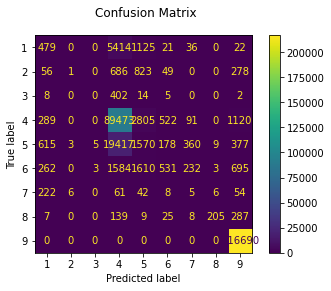

<Figure size 720x720 with 0 Axes>

In [52]:
disp = metrics.plot_confusion_matrix(rf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

### Band Importance

In [12]:
bands = [1, 2, 3, 4, 5, 6,7,8,9,10]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.03796131446919975
Band 2 importance: 0.16493721601466424
Band 3 importance: 0.15308132364361088
Band 4 importance: 0.15453980021614264
Band 5 importance: 0.15393285434656578
Band 6 importance: 0.16376191383374633
Band 7 importance: 0.17178557747607043


In [ ]:
#scientific comment on band importance

In [13]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict      1      2     3       4       5      6     7     8  9       10  \
truth                                                                        
1        66022      0     0       0       0      0     0     0  0     4949   
2            0  17147     0       0       0      0     0     0  0     1789   
3            0      0  4156       0       0      0     0     0  0      160   
4            0      0     0  930592       0      0     0     0  0    12403   
5            0      0     0       0  208562      0     0     0  0    16777   
6            0      0     0       0       0  42769     0     0  0     6436   
7            0      0     0       0       0      0  3921     0  0      114   
8            0      0     0       0       0      0     0  4959  0     1840   
9            0      0     0       0       0      0     0     0  1        0   
10           0      0     0       0       0      0     0     0  0  2166902   
All      66022  17147  4156  930592  208562  42769  3921  4959  